#Edible Flower Identification
##Objective
To build a model to identify the 9 edible flowers listed in EdibleWildFoods.com using Deep Learning and fast.ai
###Data Sources
EdibleWildFoods.com is the primary source. Pl@ntNet and Google Images are also used as supplemental data
### Methods
Resnet, a Convolutional Neural Network, is the primary algorithm being used. The architecture used are resnet18, resnet34 and resnet50

Install all the required libraries, mainly the fast.ai library. The latest code from fast.ai's github is used to manually upgrade the package just to include the latest fix for plot_top_losses function



In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
!pip install --upgrade git+https://github.com/fastai/fastai.git

     |████████████████████████████████| 720 kB 12.2 MB/s 
     |████████████████████████████████| 1.2 MB 39.5 MB/s 
     |████████████████████████████████| 189 kB 50.4 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 51 kB 301 kB/s 
Mounted at /content/gdrive
  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-qjphke6w
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-qjphke6w
  Created wheel for fastai: filename=fastai-2.5.4-py3-none-any.whl size=187080 sha256=c1ca9091f5182b2fc38fd7a0e8fb6df5a116bf7ab565d7c097cb174926a3bc27
  Stored in directory: /tmp/pip-ephem-wheel-cache-zxheesbt/wheels/e2/81/30/9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 2.5.3
    Uninstalling fastai-2.5.3:
      Successfully uninstalled fastai-2.5.3


In [ ]:
from fastbook import *

Check if the path is fine and the images are available in the desired path

In [ ]:
path = 'gdrive/MyDrive/edible-flowers'
fns = get_image_files(path)
fns

(#3960) [Path('gdrive/MyDrive/edible-flowers/calendula/calendula-flower.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/calendula-flowers.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/Calendula-officinalis.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/pot-marigold.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/44c58eeaf97991d90c8b0e517b24003e7d5541cc.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/411d7bc177c6716f7be2cec6ab1ef9a896431b77.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/a7512646f979ee96208cc65fcd484ea386b968ab.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/692f574ccc4ad365f2a24526d4f6d18f2a074f79.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/f94227424824e63776fdf26388d3097c405a3d17.jpg'),Path('gdrive/MyDrive/edible-flowers/calendula/3d1696d5090355f430c3def171ed8d425050107c.jpg')...]

Use the DataBlock api, setting these parameter values:


> Resize(460) : apply this pre-sizing for each image so all images are of the same size


> aug_transforms(size=224, min_scale=0.75): apply data augmentation transforms at the batch level


> RandomSplitter(valid_pct=0.4, seed=42): 60-40 splitting of the data into training and validation respectively

At this point, google image data is excluded just to see how the model does with fewer data







In [ ]:
edible_foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label
    )

dls = edible_foods.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


Take a look at a small batch to ensure the Data Loader has applied the labels to the data as expected

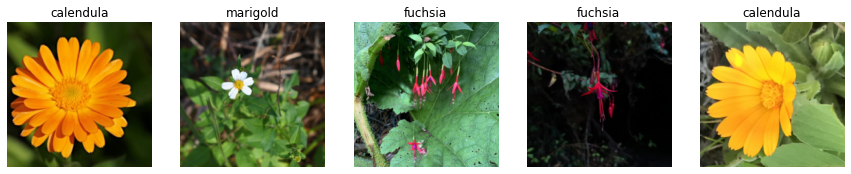

In [ ]:
dls.valid.show_batch(ncols=5, nrows=1)

Check the size of the training and validation sets

In [ ]:
print(len(dls.valid.get_idxs()))
print(len(dls.train.get_idxs()))

98
148


Using resnet34, take a look at where the default learning rate falls on the curve. This will be helpful to come up with a better learning rate or a discriminative learning rate depending on how well the baseline performs 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0012022644514217973)

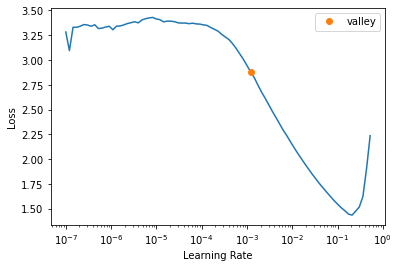

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

Based on the learning rate finder's result above, I am choosing to train the last few newly added layers (fit_one_cycle) with an appropriate learning rate. Note that, by default, fast.ai has frozen all the beginning layers to try to use the pre-trained weights while just training the last few layers will make the transfer learning more effective for this particular data

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 0.00055)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.337991,4.449076,0.836735,00:38
1,3.296577,3.074228,0.765306,00:18
2,3.013853,2.458813,0.714286,00:19


With a slightly higher learning rate, the error rate is higher now:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 0.001)

epoch,train_loss,valid_loss,error_rate,time
0,3.662238,4.664114,0.908163,00:18
1,3.442987,2.853848,0.806122,00:18
2,3.144150,2.081426,0.714286,00:19


With new weights for the newly added linear layers from above, unfreeze all the layers and look at the learning rate finder

SuggestedLRs(valley=9.120108734350652e-05)

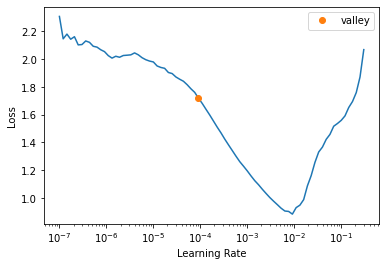

In [ ]:
learn.unfreeze()
learn.lr_find()

Using the learning rates in the above steps, run the whole modeling from the beginning using the appropriate learning rate for the last few linear layers and a discriminative learning rate (lr_max=slice(1e-6,0.00055)) after unfreezing all the layers

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 0.00055)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,0.00055))

epoch,train_loss,valid_loss,error_rate,time
0,3.301588,4.161438,0.938776,00:18
1,3.201485,3.042213,0.867347,00:18
2,3.017096,2.482922,0.734694,00:18


epoch,train_loss,valid_loss,error_rate,time
0,2.435237,2.235404,0.673469,00:19
1,2.560213,1.933713,0.622449,00:19
2,2.463750,1.543559,0.551020,00:19
3,2.272876,1.207410,0.428571,00:19
4,2.113813,0.963974,0.306122,00:19
5,1.924275,0.819729,0.275510,00:19
6,1.772272,0.742938,0.255102,00:19
7,1.617697,0.699631,0.234694,00:19
8,1.519978,0.672192,0.224490,00:19
9,1.394245,0.661488,0.204082,00:19


The error rate has improved but still not great. Take a look at the images that are being incorrectly classified sorted by the probability of the prediction

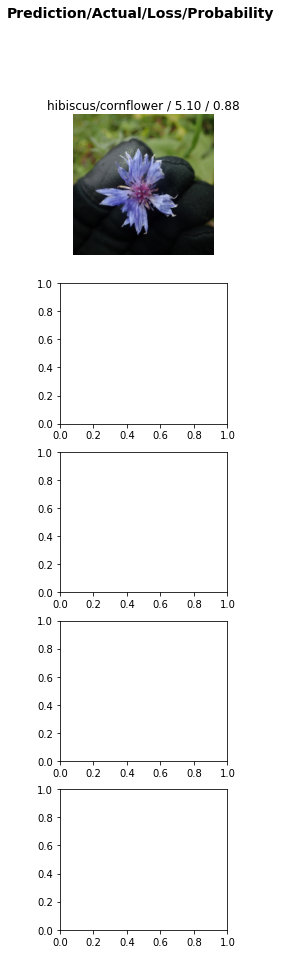

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=5)

Now, I am changing the architecture to use resnet50 without touching the default learning rate

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,3.585268,3.137407,0.846939,00:19
1,3.135133,1.323049,0.336735,00:18
2,2.319384,0.984239,0.234694,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.257850,0.829675,0.214286,00:19
1,0.208326,0.723012,0.153061,00:19
2,0.179989,0.672948,0.163265,00:19
3,0.152172,0.625784,0.142857,00:19
4,0.129846,0.606873,0.153061,00:19
5,0.112415,0.598671,0.132653,00:20


The error rate is improving. I am increasing the number of epochs to see what happens

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,3.467553,2.677255,0.795918,00:19
1,3.045640,1.962697,0.632653,00:18
2,2.335161,1.630251,0.438776,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.259567,1.197322,0.336735,00:20
1,0.218411,0.965492,0.285714,00:20
2,0.194788,0.865978,0.265306,00:19
3,0.154181,0.816350,0.224490,00:19
4,0.129251,0.789653,0.193878,00:20
5,0.110050,0.763205,0.193878,00:20
6,0.098487,0.724411,0.153061,00:20
7,0.085925,0.722834,0.153061,00:20
8,0.075596,0.733634,0.153061,00:20
9,0.068927,0.736897,0.153061,00:20


Accuracy is improving. I am trying a discriminative learning rate here:

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3, 0.00055)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,0.00055))

epoch,train_loss,valid_loss,error_rate,time
0,3.670816,3.592050,0.969388,00:19
1,2.927416,1.941549,0.755102,00:19
2,2.325828,1.377131,0.438776,00:19


epoch,train_loss,valid_loss,error_rate,time
0,1.176568,1.191890,0.397959,00:20
1,1.035228,0.966803,0.285714,00:20
2,0.955492,0.760757,0.193878,00:20
3,0.792401,0.677763,0.173469,00:20
4,0.678849,0.645531,0.153061,00:20
5,0.591953,0.640771,0.142857,00:20
6,0.518241,0.636218,0.142857,00:20
7,0.459175,0.650438,0.142857,00:20
8,0.408282,0.667902,0.142857,00:20
9,0.366372,0.684914,0.142857,00:21


###Google Images
Lets try training the same model with more images downloaded from google. There are about 500 images more on average per category now.

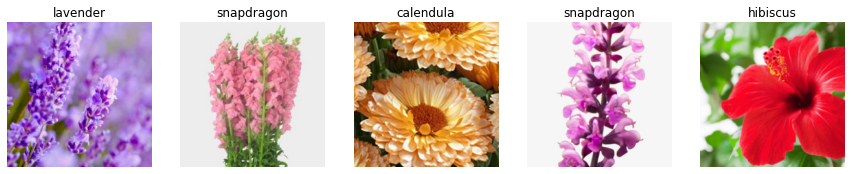

In [ ]:
dls.valid.show_batch(ncols=5, nrows=1)

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.523646,0.563291,0.167929,07:38
1,0.862766,0.487440,0.137626,02:45
2,0.607925,0.450182,0.142677,02:43


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

epoch,train_loss,valid_loss,error_rate,time
0,0.281895,0.331564,0.104798,02:55
1,0.231367,0.280502,0.089015,02:58
2,0.203919,0.372546,0.092803,02:56
3,0.187548,0.380152,0.100379,02:57
4,0.171316,0.348709,0.087121,02:59
5,0.133845,0.353036,0.078283,02:58
6,0.114630,0.350078,0.078283,02:54
7,0.089812,0.348243,0.083333,02:52
8,0.060494,0.317620,0.071970,02:52
9,0.046939,0.308828,0.070707,02:54


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

The accuracy has improved drastically as you can see above just by adding more data. Take a look at the train-validation split:

In [ ]:
print(len(dls.valid.get_idxs()))
print(len(dls.train.get_idxs()))

1584
2376


Since there was already a significant improvement without doing anything with the learning rate, take a look at the learning rate finder just to be sure another learning rate wouldn't give any better result

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

SuggestedLRs(valley=0.0008317637839354575)

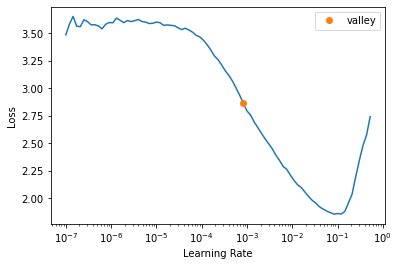

In [ ]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fit_one_cycle(3, 0.00055)

epoch,train_loss,valid_loss,error_rate,time
0,1.635401,0.507178,0.155934,04:49
1,0.882332,0.395583,0.118056,02:36
2,0.566455,0.382264,0.116793,02:34


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


SuggestedLRs(valley=0.00013182566908653826)

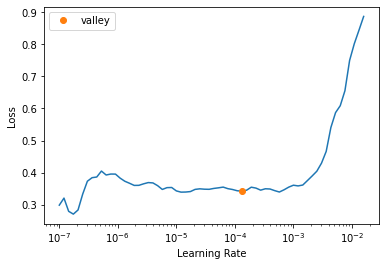

In [ ]:
learn.unfreeze()
learn.lr_find()

### Conclusions


*   Not just the availability of more training data but high quality data with various perspectives is important for a plant or flower identification model[1].
*   Choosing a slightly more complex architecture with more layers (resnet34 vs resnet50) worked well in this case.

I have explained the whole study in detail here: https://medium.com/@dinesh.k.murali14/identifying-potentially-edible-flowers-using-deep-learning-fastai-3cd18bee5dd5

### References
1. https://plantmethods.biomedcentral.com/articles/10.1186/s13007-019-0462-4